In [53]:
import pickle
import os
from typing import List, Dict, Tuple

class FLConfiguration:
    def __init__(self, date, time, db, strat_variant, d, ck, opt, dur, rounds=None):
        self.date = date
        self.time = time # time when the simulation was run
        self.db = db
        self.variant = strat_variant
        self.d = d
        self.ck = ck
        self.opt = opt
        self.clients = 10
        self.rounds = rounds
        self.duration = dur # how long it took

    def __str__(self):
        return '{}/{}/'.format(self.date, self.time) + '_'.join([self.db, self.variant, 'd{}'.format(self.d), 'CK{}'.format(self.ck)])

EXPERIMENTS: List[FLConfiguration] = []
for day in os.listdir('outputs'):
    if day.startswith('.'):
        continue
    for time in os.listdir(os.path.join('outputs', day)):
        if time.startswith('.'):
            continue
        for exp in os.listdir(os.path.join('outputs', day, time)):
            if exp.startswith('.'):
                continue           
            curr_folder = os.path.join('outputs', day, time, exp)
            if 'results.pkl' in os.listdir(curr_folder):
                fields = exp.split('_')
                d = int(fields[2].replace('d', ''))
                ck = int(fields[3].replace('CK', ''))

                log_file = [f for f in os.listdir(curr_folder) if '.log' in f][0]
                opt = log_file.split('_')[1].replace('.log', '')

                with open(curr_folder + '/' + log_file) as log:
                    lines = log.readlines()
                    dur = [l for l in lines if 'FL finished in' in l][0]
                    dur = float(dur.split('FL finished in ')[1].replace('\n', ''))
                
                EXPERIMENTS.append(FLConfiguration(day, time, fields[0], fields[1], d, ck, opt, dur))
data = []
results: Dict[FLConfiguration, Tuple[List[float], List[float]]] = {}
for exp in EXPERIMENTS:
    file_path = 'outputs/{}/results.pkl'.format(str(exp))
    with open(file_path, 'rb') as file:
        data.append(pickle.load(file))
        latest_acc = [tup[1] for tup in data[-1]['history'].metrics_centralized['accuracy']]
        latest_loss = [tup[1] for tup in data[-1]['history'].losses_centralized]
        exp.rounds = len(latest_acc)
        results[exp] = (latest_acc, latest_loss)

print('Found {} experiments'.format(len(EXPERIMENTS)))

Found 60 experiments


/var/folders/wf/vl_sy5yj7fjgz0r9rn5xbvf00000gn/T/ipykernel_24658/882848691.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/wf/vl_sy5yj7fjgz0r9rn5xbvf00000gn/T/ipykernel_24658/882848691.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


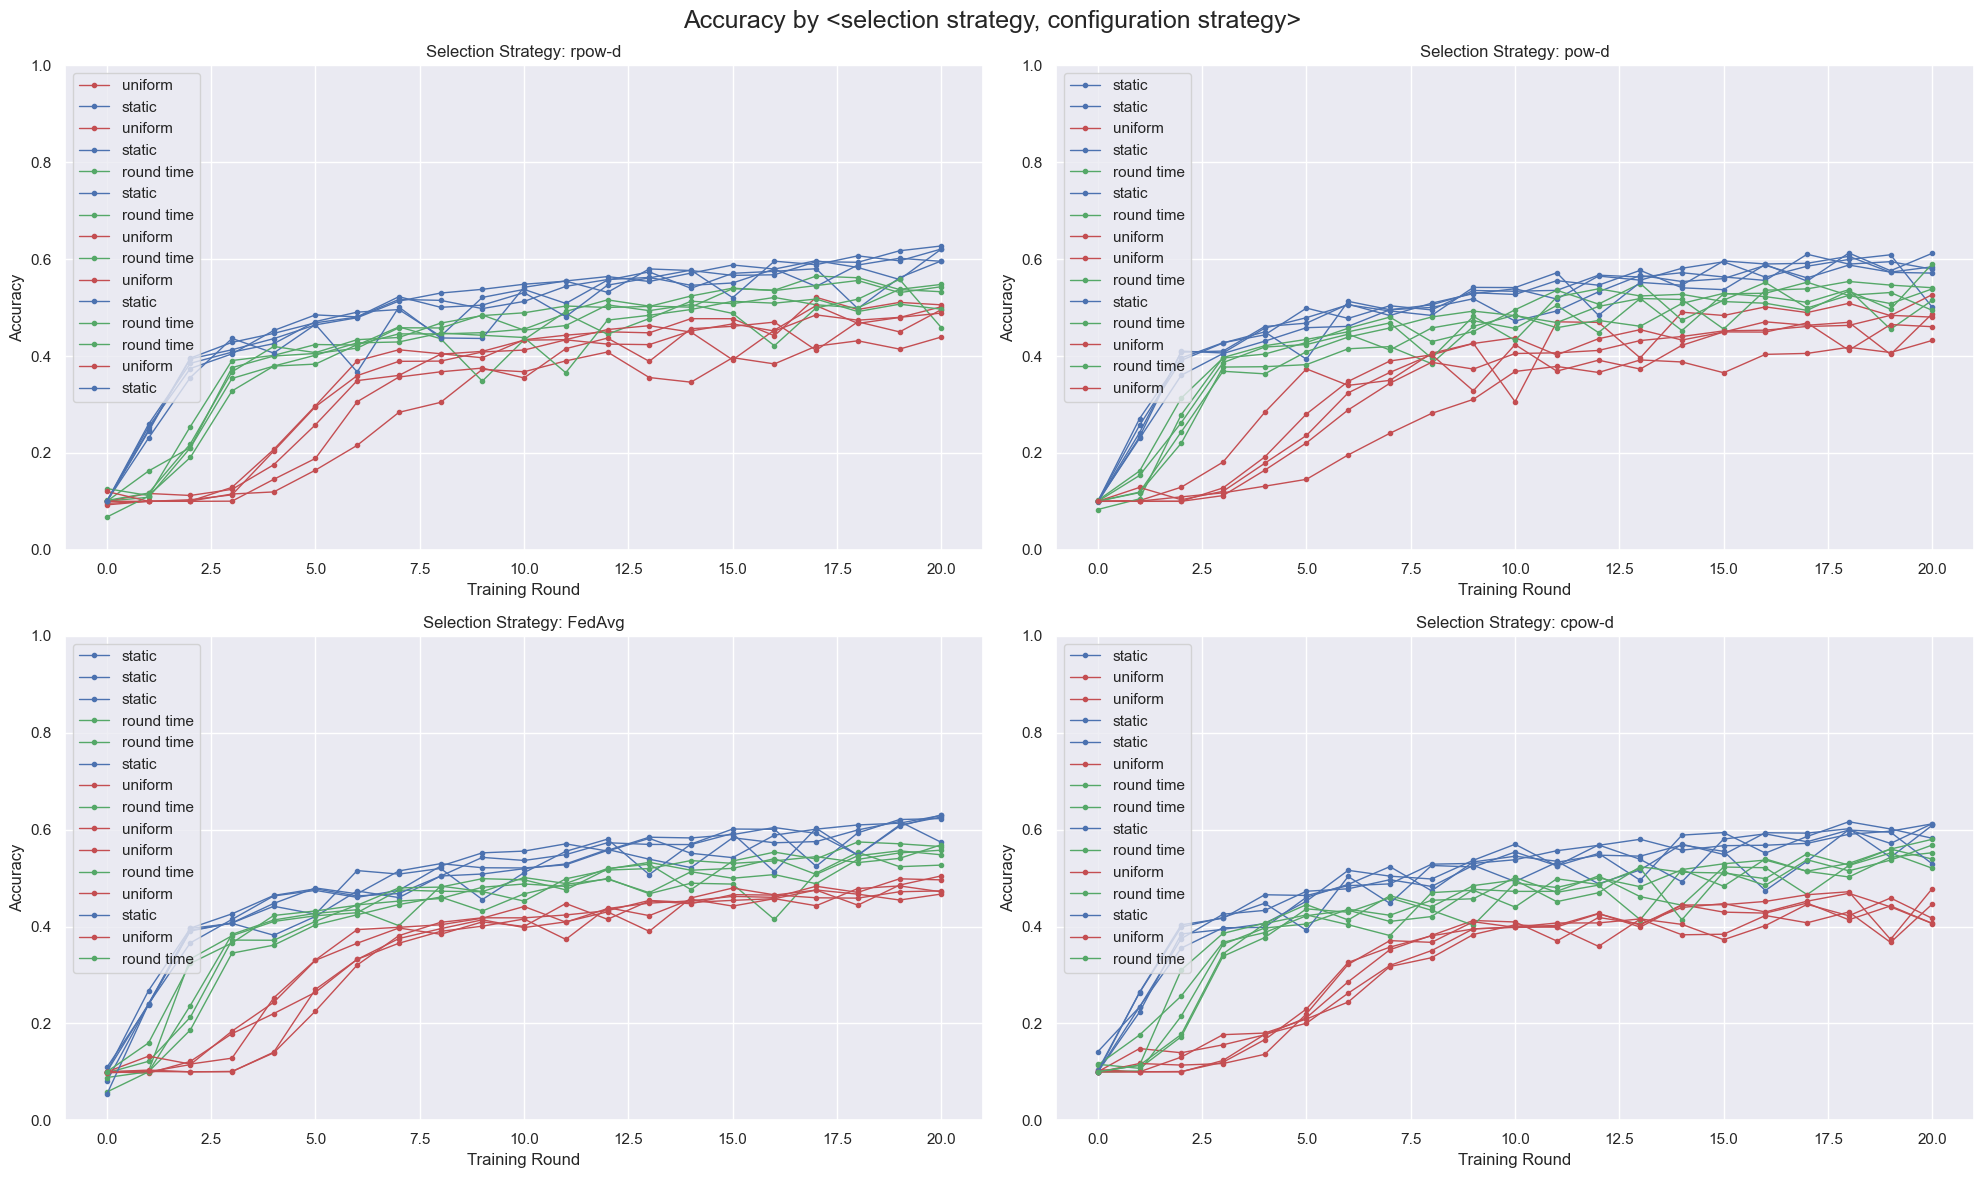

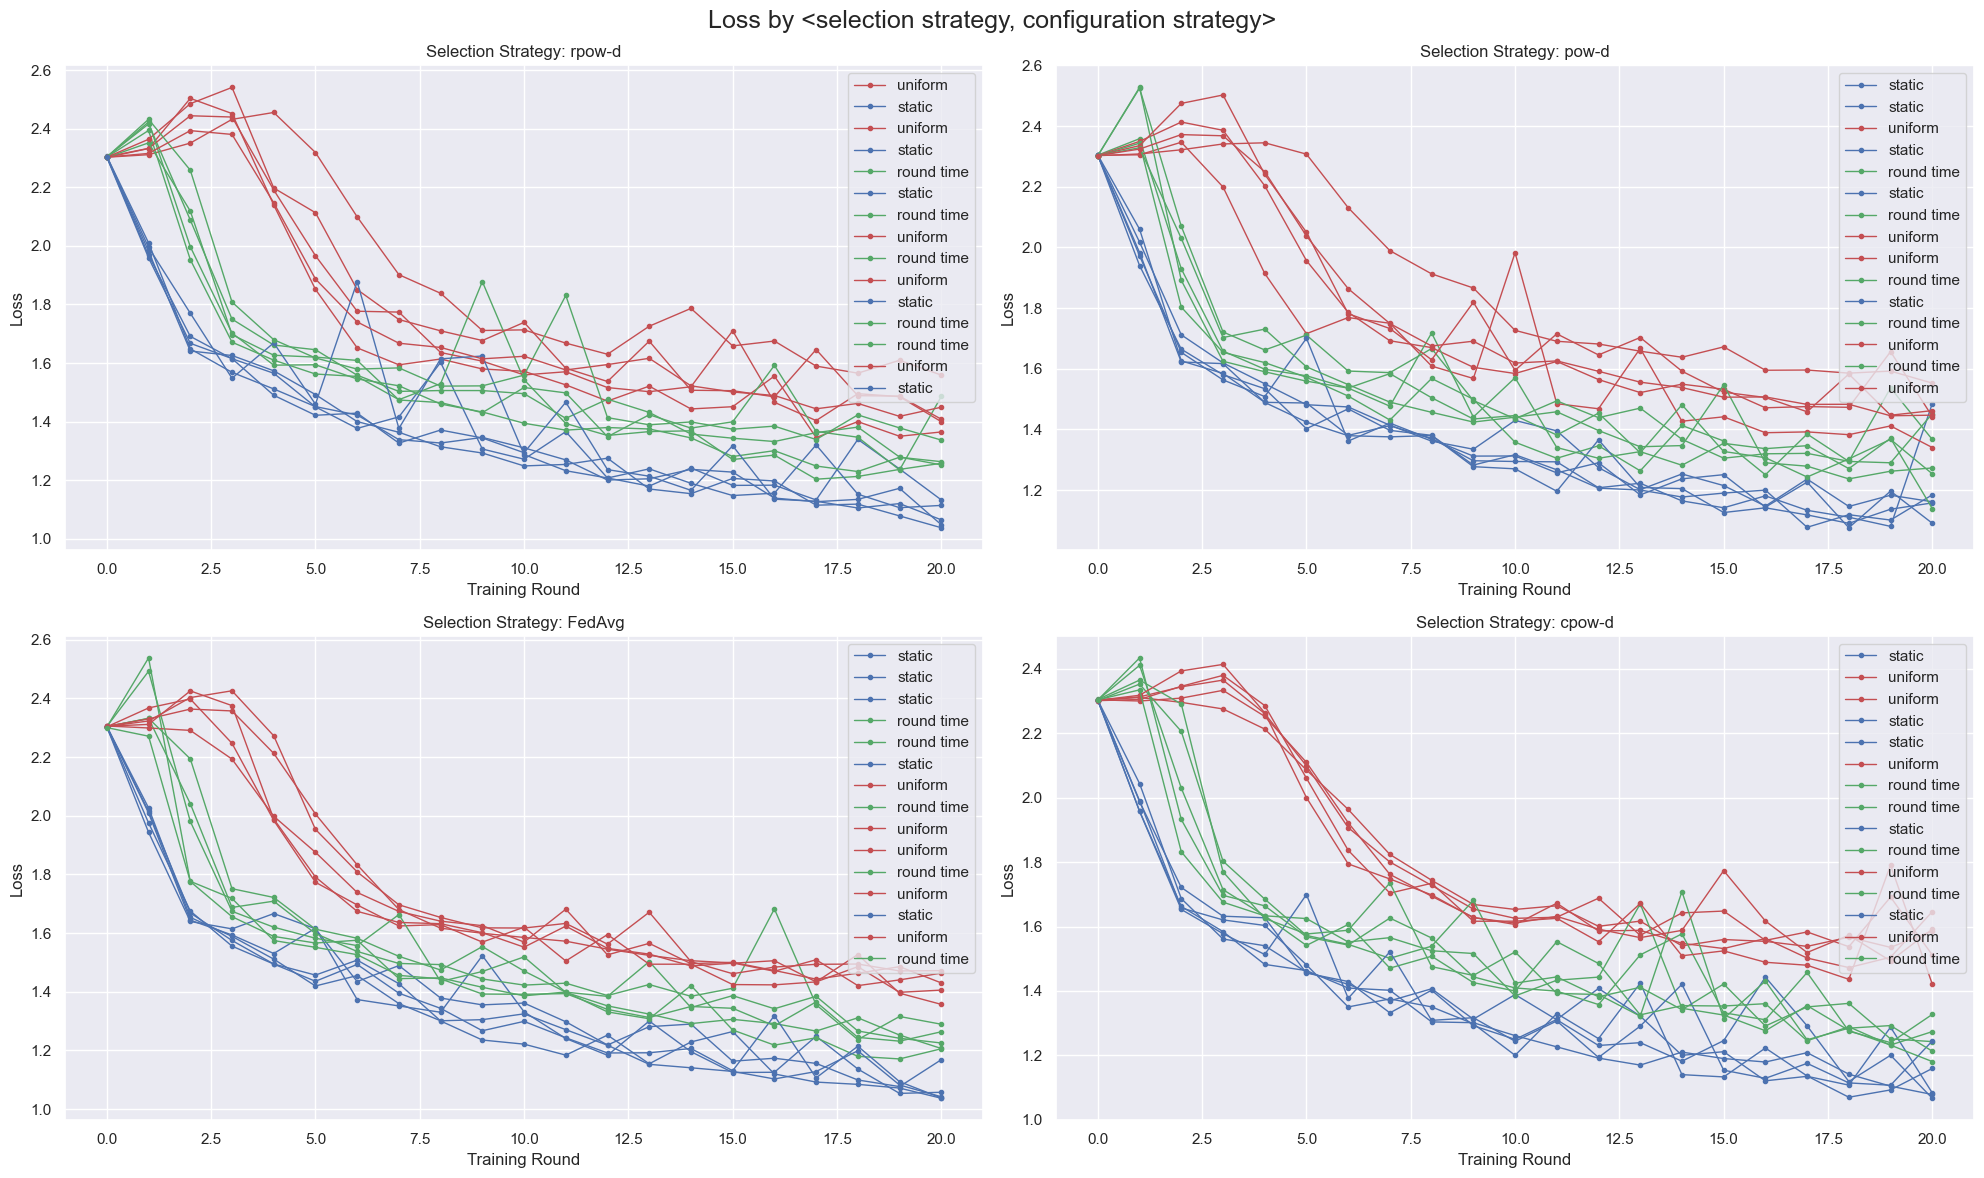

In [54]:
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'so': 'b', 'uo': 'r', 'rt': 'g', 'ecto': 'k'}

strats = list(set([exp.variant for exp in EXPERIMENTS]))
N = 2

fig, ax = plt.subplots(len(strats)//N, N, figsize=(20,12))

for exp in EXPERIMENTS:
    i = strats.index(exp.variant)
    ax[i//N, i%N].plot(range(exp.rounds), results[exp][0], marker='o', linewidth=1, markersize=3, color=colors[exp.opt], label=conf_labels[exp.opt])

for i, strat in enumerate(strats):
    ax[i//N, i%N].set_title('Selection Strategy: {}'.format(strat_labels[strat]))
    ax[i//N, i%N].set_xlabel('Training Round')
    ax[i//N, i%N].set_ylabel('Accuracy')
    ax[i//N, i%N].set_ylim([0, 1])
    ax[i//N, i%N].grid(True)
    ax[i//N, i%N].legend()

fig.suptitle('Accuracy by <selection strategy, configuration strategy>', fontsize=18)
fig.tight_layout()
fig.savefig('plot_accuracy.png', format='png')
fig.show()

fig, ax = plt.subplots(len(strats)//N, N, figsize=(20,12))

for exp in EXPERIMENTS:
    i = strats.index(exp.variant)
    ax[i//N, i%N].plot(range(exp.rounds), results[exp][1], marker='o', linewidth=1, markersize=3, color=colors[exp.opt], label=conf_labels[exp.opt])

for i, strat in enumerate(strats):
    ax[i//N, i%N].set_title('Selection Strategy: {}'.format(strat_labels[strat]))
    ax[i//N, i%N].set_xlabel('Training Round')
    ax[i//N, i%N].set_ylabel('Loss')
    ax[i//N, i%N].grid(True)
    ax[i//N, i%N].legend()

fig.suptitle('Loss by <selection strategy, configuration strategy>', fontsize=18)
fig.tight_layout()
fig.savefig('plot_loss.png', format='png')
fig.show()



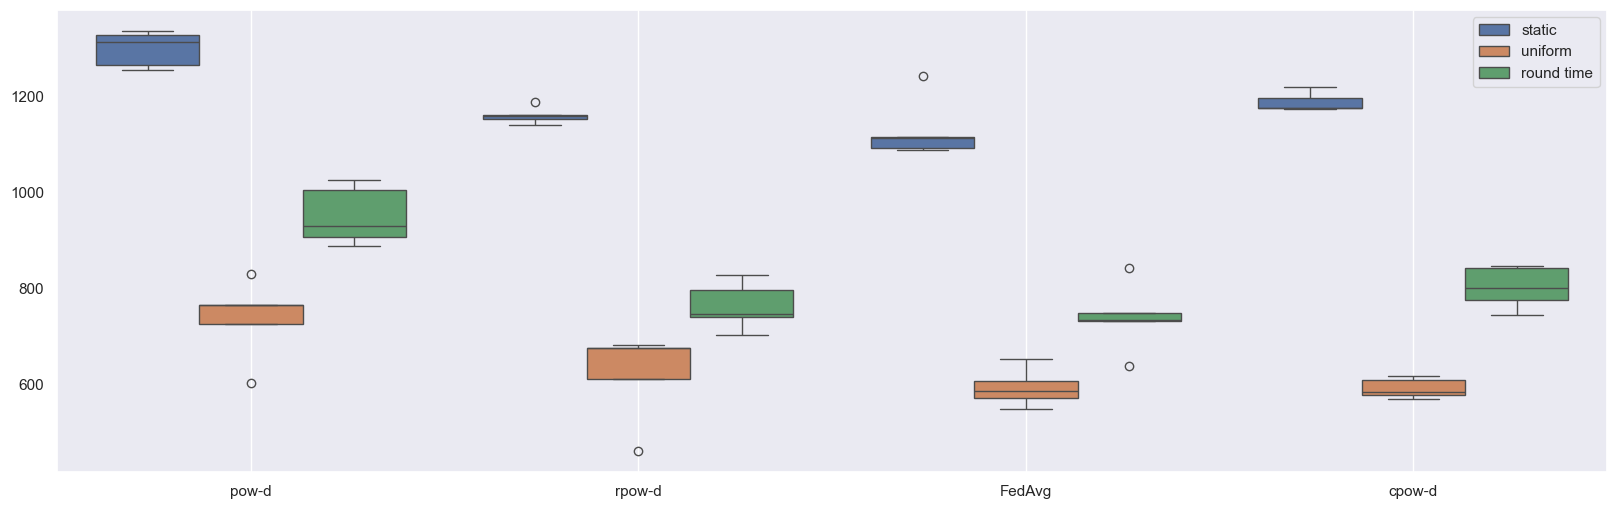

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'so': 'b', 'uo': 'r', 'rt': 'g', 'ecto': 'k'}

x = [strat_labels[exp.variant] for exp in EXPERIMENTS]
y = [exp.duration for exp in EXPERIMENTS]
hue = [conf_labels[exp.opt] for exp in EXPERIMENTS]

sns.set_theme(rc={'figure.figsize':(20, 6)})
sns.boxplot(x=x, y=y, hue=hue)
plt.grid()  
plt.show()